In [2]:
import numpy as np 
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

import cufflinks as cf
cf.set_config_file(offline = True)

import yfinance as yf

# Ignore warnings - optional
import warnings
warnings.filterwarnings('ignore')

### Black-Scholes Model Price function for Vanilla European Options

In [3]:
def BlackScholesPrice(S0, K, r, T, sigma, type = 'Call'):
    
    d1 = (np.log(S0 / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if type == 'Put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
        return  price
    
    else:
        price = S0 * norm.cdf(d1) - norm.cdf(d2) * K * np.exp(-r * T)
        return price
        
S0, K, r, T, sigma = 100, 100, 0.05, 1, 0.2       
CE = BlackScholesPrice(S0, K, r, T, sigma)   
CE

10.450583572185572

In [4]:
# Simulating stock paths using geometric brownian motion

def GBM(S0, rf, T, vol, nsteps, nsims):

  
    dt = T/nsteps                       # time steps we are taking say, we want to do daily simulation that means nsteps = 252
    
    S = np.zeros((nsims,nsteps+1))     # just a initialisation of values'S' will take , for now we assume it to be all zero, remember the excel framework of simulation shown by sir
    
    S[:,0] = S0
    
    for i in range (nsteps):
        
        phi = np.random.randn(nsims)     # just a first column vector of 'z'(standard normal) values initiated , its like normsinv(rand) in excel
        
        S[:,i+1] = S[:,i]*np.exp((rf-0.5*vol*vol)*dt + vol*phi*np.sqrt(dt))
        
    return S                              # S is a two dimensional numpy array


In [5]:
nsteps = 252
nsims = 10000
S0, K, rf, T, vol = 100, 100, 0.05, 1, 0.2
paths= pd.DataFrame(GBM(S0,rf,T,vol,nsteps,nsims))
paths.head()


,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,100.0,98.675748,98.917771,101.562896,101.595552,100.915869,100.729217,101.418787,101.518703,102.490721,...,94.250523,95.536544,96.536696,97.987309,95.158895,94.189043,94.487840,94.624868,95.345171,96.369360
1,100.0,99.716801,99.851510,98.346560,98.301104,96.162041,95.910196,97.573597,96.900742,96.153835,...,103.706294,103.684189,102.752015,101.130897,101.153939,101.534336,100.166045,100.956389,100.658227,101.733038
2,100.0,100.527165,101.643211,102.358283,100.213697,99.395501,99.999306,101.023623,102.651965,103.837942,...,102.633375,99.288169,99.028822,98.716351,99.495842,100.740104,101.523902,101.088376,101.160582,102.442384
3,100.0,101.431314,99.806919,101.462680,101.828048,100.920413,99.837899,98.043129,100.930018,100.463004,...,114.801942,116.621999,117.326358,116.390232,118.329083,116.307003,114.035615,114.697066,115.562193,114.747624
4,100.0,100.541762,100.696768,99.778231,98.942635,97.959701,96.041851,95.204497,91.421065,90.129248,...,74.549491,74.446944,74.798449,74.346417,75.179301,74.249863,74.398140,74.356151,75.029605,74.509649


Text(0.5, 1.0, 'Geometric Brownian Motion')

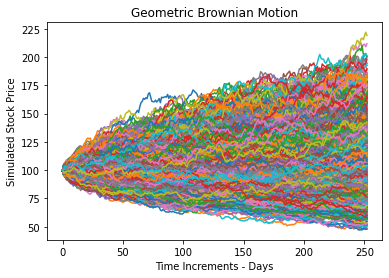

In [6]:
plt.plot(paths.T);
plt.xlabel("Time Increments - Days")
plt.ylabel("Simulated Stock Price")
plt.title("Geometric Brownian Motion")

We are looking to price a lookback option with fixed strike 
We are using Monte carlo to simulate a underlying price at each time step(252 days)


In [7]:
# This gives maximum value of stock for every simulation
# per simulation we are extracting max of stock price that is we are looking columnwise(as per our data format)
S_max = paths.max(axis = 1) 
S_max

0       108.218327
1       111.591698
2       119.805608
3       140.974672
4       100.696768
           ...    
9995    114.165756
9996    145.884469
9997    112.222727
9998    142.873235
9999    112.348003
Length: 10000, dtype: float64

In [8]:
Payoff_lookback = np.maximum(S_max - K, 0)
lookback_price = np.mean(Payoff_lookback)*np.exp(-r*T)
print(f"fixed lookback call price is {lookback_price}")

fixed lookback call price is 18.296582097782387


In [8]:
# Time steps we are taking
dt = 1 / nsteps

# Generate random paths for the stock price using GBM
def stock_price_paths(S0, rf, T, vol, nsteps, nsims):
    S = np.zeros((nsims, nsteps + 1))
    S[:, 0] = S0
    for i in range(nsteps):
        phi = np.random.randn(nsims)
        S[:, i + 1] = S[:, i] * np.exp((rf - 0.5 * vol**2) * dt + vol * phi * np.sqrt(dt))
    return S

paths = stock_price_paths(S0, rf, T, vol, nsteps, nsims)

# Calculate lookback option payoffs at each time step
option_prices = np.zeros(nsteps)
for t in range(1, nsteps + 1):
    lookback_option_payoffs = np.maximum(paths[:,:t].max(axis=1) - K, 0)
    option_prices[t - 1] = np.exp(-rf * t* dt) *lookback_option_payoffs.mean()


option_price_df = pd.DataFrame({'LC price': option_prices})
option_price_df

,LC price
0,0.000000
1,0.518406
2,0.883746
3,1.181376
4,1.432306
...,...
247,18.449576
248,18.490399
249,18.534673
250,18.581055


In [9]:
# Assume that lookback option we had above was on oogle for 252 days and now we import equity price data from yahoo finance
equity = yf.download('GOOG', start = '2022-10-13' ,end = '2023-10-14',progress = False, interval = '1d')
equity.index = equity.index.date

In [10]:
Prices = equity['Adj Close']
Prices.shape

(252,)

In [11]:
data = {
    'Option_price': option_price_df.values.ravel(),
    'Equity_price': Prices,
    'Strike' : [100]*252,
    'rf': [0.05]*252,
    'T' : [(i + 1) / 252 for i in range(len(Prices))],
    'Sigma': [0.2]*252
}

df = pd.DataFrame(data, index=equity.index)
df

,Option_price,Equity_price,Strike,rf,T,Sigma
2022-10-13,0.000000,99.709999,100,0.05,0.003968,0.2
2022-10-14,0.518406,97.180000,100,0.05,0.007937,0.2
2022-10-17,0.883746,100.779999,100,0.05,0.011905,0.2
2022-10-18,1.181376,101.389999,100,0.05,0.015873,0.2
2022-10-19,1.432306,100.290001,100,0.05,0.019841,0.2
...,...,...,...,...,...,...
2023-10-09,18.449576,139.500000,100,0.05,0.984127,0.2
2023-10-10,18.490399,139.199997,100,0.05,0.988095,0.2
2023-10-11,18.534673,141.699997,100,0.05,0.992063,0.2
2023-10-12,18.581055,140.289993,100,0.05,0.996032,0.2


In [12]:
def delta(Equity_price ,Strike , rf, T, Sigma):
    d1 = (np.log(Equity_price / Strike) + (rf + Sigma ** 2 / 2) * T) / (Sigma * np.sqrt(T))
    N = norm.cdf(d1)
    return N


def gamma(Equity_price ,Strike , rf, T, Sigma):
    d1 = (np.log(Equity_price / Strike) + (rf + Sigma ** 2 / 2) * T) / (Sigma * np.sqrt(T))
    return norm.pdf(d1)/(Equity_price*Sigma*np.sqrt(T))

# Black-Scholes Vega function
def vega(Equity_price ,Strike , rf, T, Sigma):
    d1 = (np.log(Equity_price / Strike) + (rf + Sigma ** 2 / 2) * T) / (Sigma * np.sqrt(T))
    vega = Equity_price * np.sqrt(T) * norm.pdf(d1)
    return vega


def theta(Equity_price ,Strike , rf, T, Sigma):
    d1 = (np.log(Equity_price / Strike) + (rf + Sigma ** 2 / 2) * T) / (Sigma * np.sqrt(T))
    d2 = d1 - Sigma * np.sqrt(T)
    p1 = - Equity_price*norm.pdf(d1)*Sigma / (2 * np.sqrt(T))
    p2 = rf*Strike*np.exp(-rf*T)*norm.cdf(d2) 
    return p1 - p2



def calculate_delta(row):
    return delta(row['Equity_price'], row['Strike'], row['rf'], row['T'],row['Sigma'])

def calculate_gamma(row):
    return gamma(row['Equity_price'], row['Strike'], row['rf'], row['T'],row['Sigma'])

def calculate_vega(row):
    return vega(row['Equity_price'], row['Strike'], row['rf'], row['T'],row['Sigma'])

def calculate_theta(row):
    return theta(row['Equity_price'], row['Strike'], row['rf'], row['T'],row['Sigma'])




df['delta'] = df.apply(calculate_delta, axis = 1)
df['gamma'] = df.apply(calculate_gamma, axis = 1)
df['vega'] =  df.apply(calculate_vega, axis = 1)
df['theta'] = df.apply(calculate_theta, axis = 1)
df['APL'] = df['Option_price'].diff()
df['HPL'] = np.nan
df['RTPL'] = np.nan
df['VaR'] = np.nan
df


,Option_price,Equity_price,Strike,rf,T,Sigma,delta,gamma,vega,theta,APL,HPL,RTPL,VaR
2022-10-13,0.000000,99.709999,100,0.05,0.003968,0.2,0.417432,0.310745,2.451950,-63.851326,NaN,NaN,NaN,NaN
2022-10-14,0.518406,97.180000,100,0.05,0.007937,0.2,0.057711,0.066729,1.000298,-12.882051,0.518406,NaN,NaN,NaN
2022-10-17,0.883746,100.779999,100,0.05,0.011905,0.2,0.653299,0.167840,4.058769,-37.317789,0.365341,NaN,NaN,NaN
2022-10-18,1.181376,101.389999,100,0.05,0.015873,0.2,0.723053,0.131060,4.277097,-30.515645,0.297630,NaN,NaN,NaN
2022-10-19,1.432306,100.290001,100,0.05,0.019841,0.2,0.560443,0.139577,5.570952,-30.821427,0.250930,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-09,18.449576,139.500000,100,0.05,0.984127,0.2,0.978569,0.001855,7.104346,-5.320567,0.046225,NaN,NaN,NaN
2023-10-10,18.490399,139.199997,100,0.05,0.988095,0.2,0.977866,0.001906,7.299586,-5.331474,0.040822,NaN,NaN,NaN
2023-10-11,18.534673,141.699997,100,0.05,0.992063,0.2,0.982060,0.001564,6.230213,-5.249115,0.044275,NaN,NaN,NaN
2023-10-12,18.581055,140.289993,100,0.05,0.996032,0.2,0.979591,0.001759,6.896360,-5.295049,0.046382,NaN,NaN,NaN


In [13]:
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)

Hypothetical PnL:
The HPL must be calculated by revaluing the positions held at the end of the previous day using the market data of the present day (ie using static positions).

Risk-theoritical PnL:
The RTPL is the daily trading desk-level P&L that is produced by the valuation engine of the trading desk’s risk management model.

In [14]:
for i in range(1, len(df)):
    df.at[i, 'HPL'] = (df.at[i - 1,'delta'])* (df.at[i, 'Equity_price'] - df.at[i - 1,'Equity_price']) + \
                      (0.5) * (df.at[i - 1, 'gamma']) * ((df.at[i, 'Equity_price'] - df.at[i - 1, 'Equity_price'])** 2) + \
                      df.at[i -1, 'theta'] * (df.at[i, 'T'] - df.at[i - 1, 'T'])
    
    df.at[i,'RTPL'] = (df.at[i - 1,'delta'] * df.at[i, 'Equity_price']) -(df.at[i - 1, 'delta'] * df.at[i - 1, 'Equity_price'])
    df.at[i, 'VaR'] = df.at[i - 1,'Equity_price'] *df.at[i - 1, 'delta'] *df.at[i - 1,'Sigma'] *np.sqrt(1/250)* norm.ppf(0.01)


df    

,Date,Option_price,Equity_price,Strike,rf,T,Sigma,delta,gamma,vega,theta,APL,HPL,RTPL,VaR
0,2022-10-13,0.000000,99.709999,100,0.05,0.003968,0.2,0.417432,0.310745,2.451950,-63.851326,NaN,NaN,NaN,NaN
1,2022-10-14,0.518406,97.180000,100,0.05,0.007937,0.2,0.057711,0.066729,1.000298,-12.882051,0.518406,-0.314956,-1.056102,-1.224783
2,2022-10-17,0.883746,100.779999,100,0.05,0.011905,0.2,0.653299,0.167840,4.058769,-37.317789,0.365341,0.589045,0.207759,-0.165032
3,2022-10-18,1.181376,101.389999,100,0.05,0.015873,0.2,0.723053,0.131060,4.277097,-30.515645,0.297630,0.281653,0.398513,-1.937407
4,2022-10-19,1.432306,100.290001,100,0.05,0.019841,0.2,0.560443,0.139577,5.570952,-30.821427,0.250930,-0.837160,-0.795358,-2.157248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2023-10-09,18.449576,139.500000,100,0.05,0.984127,0.2,0.978569,0.001855,7.104346,-5.320567,0.046225,0.731841,0.752478,-3.989382
248,2023-10-10,18.490399,139.199997,100,0.05,0.988095,0.2,0.977866,0.001906,7.299586,-5.331474,0.040822,-0.314604,-0.293574,-4.016986
249,2023-10-11,18.534673,141.699997,100,0.05,0.992063,0.2,0.982060,0.001564,6.230213,-5.249115,0.044275,2.429466,2.444666,-4.005469
250,2023-10-12,18.581055,140.289993,100,0.05,0.996032,0.2,0.979591,0.001759,6.896360,-5.295049,0.046382,-1.403983,-1.384708,-4.094891


### Bankwide backtest(done quarterly) based on VaR calibrated at 99th percentile confidence level
### Trading desk level backtest done daily for eligibility purpose at (99th and 97.5th confidence level)

~ Backtesting requirements compare the value-at-risk (VaR) measure calibrated to a one-day holding period against each of the actual P&L (APL) and hypothetical P&L (HPL) over the prior 12 months.

~ The whole idea is that the maximum loss expectation at 1 day 99% VaR should be enough to cover loss figure given by APL and HPL.

~ An exception or an outlier occurs when either the actual or hypothetical loss of the trading desk registered in a day of the backtesting period exceeds the corresponding daily VaR measure determined by the bank’s model.

In [15]:
# here we are exctracting columns for backtesting purpose from dataframe named df
required_columns = ['APL', 'HPL', 'RTPL','VaR']
backtesting = df[required_columns].iloc[1:].copy()

backtesting['APL_exceptions'] = np.where(backtesting['VaR'] > backtesting['APL'],1,0)
backtesting['HPL_exceptions'] = np.where(backtesting['VaR'] > backtesting['HPL'],1,0)
backtesting['APL_exceptions'].sum()
backtesting['HPL_exceptions'].sum()
bt_exception = max(backtesting['APL_exceptions'].sum(),backtesting['HPL_exceptions'].sum())
bt_exception

8

In [16]:
# to find out the multiplier we do bankwide backtesting quarterly
def backtest_zone():
    if bt_exception <= 4:
        BT_zone = 'green'
        print(f" Zone = 'Green', Multiplier is constant : 1.5 " ) # this multiplier is used in final capital calculation
    
    elif  bt_exception > 4 &  bt_exception <= 9:
        BT_zone = 'amber'
        print(f" Zone = 'Amber', Multiplier keeps on increasing with exceptions : 1.7 - 1.92 " )
    else:  # exceptions >= 10 falls in red zone
        BT_zone = 'red'
        print(f" Zone = 'Red', Multiplier is constant : 2 " )
    

backtest_zone()

 Zone = 'Amber', Multiplier keeps on increasing with exceptions : 1.7 - 1.92 


## Profit and Loss attribution test conducted at desk level daily 
~ This is just a way of quantifying whether the risk models used to calculate risk capital requirement is in sync with the risk factors used in front office for PnL reporting. It quantifies the accuracy of the risk models.

~ The PLA test compares daily risk-theoretical P&L (RTPL) with the daily HPL for each trading desk.

~ The PLA requirements are based on two test metrics:
(1) the Spearman correlation metric to assess the correlation between RTPL and HPL; and
(2) the Kolmogorov-Smirnov (KS) test metric to assess similarity of the distributions of RTPL and HPL.

~ Based on the outcome of the metrics, a trading desk is allocated to a PLA test zone: Red zone,Amber zone or a Green zone

In [17]:
# basically RTPL should mimic HPL, ideally correlation should be high
from scipy.stats import spearmanr
correlation = spearmanr(backtesting['HPL'], backtesting['RTPL'])
#print (f'spearman correlation: {correlation[0]}')
correlation

SpearmanrResult(correlation=0.9979768544868147, pvalue=5.347671265852791e-300)

In [18]:
# sort the hpl and rtpl values 
# Create a new DataFrame with sorted 'hpl' and 'rtpl' columns
plat_df = pd.DataFrame({
    'HPL_sorted': backtesting['HPL'].sort_values(ascending=True).values,
    'RTPL_sorted': backtesting['RTPL'].sort_values(ascending=True).values
})
plat_df.reset_index(drop=True, inplace=True)  # Reset index to start from 0

hplsd = backtesting['HPL'].std()
rtplsd = backtesting['RTPL'].std()
plat_df['HPL_CDF'] = norm.cdf(plat_df['HPL_sorted'], backtesting['HPL'].mean(), hplsd)
plat_df['RTPL_CDF'] = norm.cdf(plat_df['RTPL_sorted'], backtesting['RTPL'].mean(),rtplsd)
plat_df

,HPL_sorted,RTPL_sorted,HPL_CDF,RTPL_CDF
0,-7.155077,-9.197818,0.000004,1.163798e-08
1,-5.843370,-6.524489,0.000135,3.525712e-05
2,-4.774417,-4.797494,0.001406,1.674620e-03
3,-4.156689,-4.152256,0.004540,5.466212e-03
4,-3.664493,-3.685985,0.010513,1.179199e-02
...,...,...,...,...
246,3.568400,3.569049,0.983166,9.825109e-01
247,4.038804,3.920796,0.992073,9.898458e-01
248,4.824374,4.614197,0.998095,9.969140e-01
249,5.498591,4.743269,0.999528,9.975709e-01


In [19]:
KS_test = max( abs( plat_df['HPL_CDF'] - plat_df['RTPL_CDF'] ) )
print('Kolmogorov-Smirnov test metric is', KS_test)

Kolmogorov-Smirnov test metric is 0.044598711344709274


In [20]:
def plat_zone():
    
    if (correlation[0] > 0.8) and (KS_test < 0.09):
        zone = 'Green'
        print(f" Plat zone is {zone} : Trading desk is eligible for the use of IMA")
   
    elif (correlation[0] < 0.7) or (KS_test > 0.12):     # RTD's falling in this zone cant use IMA
        zone = 'red' 
        print(f"{zone} : Desk is ineligible to use the IMA to determine market risk capital requirements")
                
    
    else:
        zone = 'amber'
        print(f" {zone} : Desk is not considered an out-of-scope trading desk for use of the IMA")
    
plat_zone()
        

 Plat zone is Green : Trading desk is eligible for the use of IMA
